<a href="https://colab.research.google.com/github/SpirinEgor/HSE.Deep_Unsupervised_Learning/blob/hw11/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Wed Feb 16 15:11:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    64W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw11

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (531/531), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 1057 (delta 292), reused 325 (delta 165), pack-reused 526
Receiving objects: 100% (1057/1057), 76.76 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (524/524), done.
/content/HSE.Deep_Unsupervised_Learning
Branch 'hw11' set up to track remote branch 'hw11' from 'origin'.
Switched to a new branch 'hw11'


In [3]:
! pip install -q -r requirements.txt

In [4]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

from utils.hw11_utils import *
from contrastive.byol import BYOL
from contrastive.barlow_twins import BarlowTwins

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx][0]

def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations,) numpy array losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataset = MNISTDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    latent_dim = 128
    byol = BYOL(latent_dim, device)

    losses = byol.fit(train_dataloader, n_epochs=5)
    return losses, byol.encode, latent_dim

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Test classification:   0%|          | 0/10 [00:00<?, ?it/s]

mean classification accuracy=0.7766


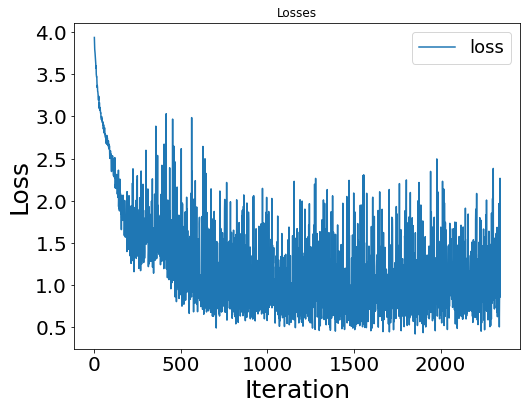

In [9]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [14]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataset = MNISTDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    latent_dim = 128
    barlow_twins = BarlowTwins(latent_dim, device)

    losses = barlow_twins.fit(train_dataloader, n_epochs=5)
    return losses, barlow_twins.encode, latent_dim

Files already downloaded and verified
Files already downloaded and verified


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Test classification:   0%|          | 0/10 [00:00<?, ?it/s]

mean classification accuracy=0.1000


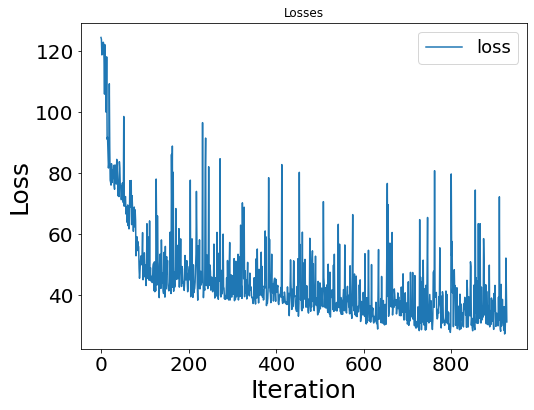

In [15]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    pass

In [ ]:
q2_results(b, True)